# RL Problem Set 3

In [126]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt

# Basic Definitions and Utilities

In [127]:
# Basic properties of the MDP
N = 100  # Maximum length of the queue
A = 2  # Number of actions
gamma = 0.99  # Discount factor
p = 0.5  # Arrival rate of requests
q_low = 0.51  # Service rate for action alow
q_high = 0.6  # Service rate for action ahigh
c_low = 0  # Cost for action alow
c_high = 0.05  # Cost for action ahigh


# Reward function based on state x and action a
def reward(x, a):
    if a == 'alow':
        return -(x / N) ** 2
    elif a == 'ahigh':
        return -(x / N) ** 2 - c_high


# Truncate function to keep queue length within bounds
def trunc(x):
    return min(N - 1, max(x, 0))


# Phi functions for the two feature maps
def phi_coarse(x, N):
    # Determine the number of bins
    num_bins = N // 5
    # Calculate the bin index for the current state x
    bin_index = x // 5
    # Create a feature vector with a length of num_bins
    feature_vector = np.zeros(num_bins)
    # Set the feature corresponding to the bin_index to 1
    feature_vector[bin_index] = 1
    return feature_vector


def phi_pwl(x, N):
    # Determine the number of bins
    num_bins = N // 5
    # Create a feature vector with a length of 2 * num_bins
    feature_vector = np.zeros(2 * num_bins)
    # Calculate the bin index for the current state x
    bin_index = x // 5
    # Set the feature corresponding to the bin_index to 1 (coarse feature)
    feature_vector[bin_index] = 1
    # Calculate and set the piecewise linear feature
    position_in_bin = x % 5
    feature_vector[num_bins + bin_index] = position_in_bin / 5.0
    return feature_vector

## Problem: Soft-Policy Iteration

### Defining of the Initial Uniform Policy and Deterministic Policy (for Hard Policy Iteration)

In [149]:
# Initial uniform policy
pi_uniform = np.full((N, A), 1 / A)

# Initialize deterministic policy
pi_deterministic = np.zeros((N, A))
# Randomly select an action for each state
for state in range(N):
    action = np.random.choice(A)  # Randomly choose an action
    pi_deterministic[state, action] = 1

### Sampling of the next state

In [129]:
# Function to generate the next state based on the current state and action
def sample_transition(x, action):
    """
    Sample the next state based on the current state and action.
    """
    increment = np.random.choice([0, 1], p=[1 - p, p])  # Arrival of new request
    if action == 'alow':  # alow
        decrement = np.random.choice([0, 1], p=[1 - q_low, q_low])  # Service completion with low rate
    else:  # action == 'ahigh'
        decrement = np.random.choice([0, 1], p=[1 - q_high, q_high])  # Service completion with high rate

    new_x = trunc(x + increment - decrement)  # New state with truncation
    return new_x

### LSTD Functions

In [131]:
def LSTD_soft(policy, feature_map, num_transitions, N, gamma, start_state=None):
    """
    Performs LSTD updates for the soft policy iteration process.
    """
    # Initialize variables
    d = len(feature_map(0, N))
    A_mat = np.zeros((d, d))
    b_vec = np.zeros(d)

    x = start_state if start_state is not None else N - 1  # Start at the provided starting state or full queue
    
    cumulative_reward = 0  # Initialize cumulative reward

    # Perform the LSTD updates
    for _ in range(num_transitions):
        # Sample action according to the stochastic policy
        action_probabilities = policy[x]
        action_index = np.random.choice([0, 1], p=action_probabilities)  # Assuming two actions: 0 and 1
        action = 'alow' if action_index == 0 else 'ahigh'
        # Calculate the reward for the current state and action
        r = reward(x, action)
        # Update cumulative reward
        cumulative_reward += r
        # Compute feature vector for current state
        phi_x = feature_map(x, N)
        # Sample a transition to the next state
        x_next = sample_transition(x, action)
        # Compute feature vector for next state
        phi_x_next = feature_map(x_next, N)
        # Update A and b (recursive least squares update)
        A_mat += np.outer(phi_x, (phi_x - gamma * phi_x_next))
        b_vec += phi_x * r
        # Update state
        x = x_next

    # Solve for the weight vector w using the Moore-Penrose pseudoinverse The 
    w = np.linalg.pinv(A_mat) @ b_vec

    # Return the weight vector and the final state
    return w, x, cumulative_reward 

In [137]:
def LSTD_hard(policy, feature_map, num_transitions, N, gamma, start_state=None):
    """
    Performs LSTD updates for the hard policy iteration process.
    """
    # Initialize variables
    d = len(feature_map(0, N))
    A_mat = np.zeros((d, d))
    b_vec = np.zeros(d)

    x = start_state if start_state is not None else N - 1  # Start at the provided starting state or full queue
    
    cumulative_reward = 0  # Initialize cumulative reward

    # Perform the LSTD updates
    for _ in range(num_transitions):
        # Choose action according to policy
        action = 'alow' if policy[x, 0] == 1 else 'ahigh'
        # Calculate the reward for the current state and action
        r = reward(x, action)
        # Update cumulative reward
        cumulative_reward += r
        # Compute feature vector for current state
        phi_x = feature_map(x, N)
        # Sample a transition to the next state
        x_next = sample_transition(x, action)
        # Compute feature vector for next state
        phi_x_next = feature_map(x_next, N)
        # Update A and b (recursive least squares update)
        A_mat += np.outer(phi_x, (phi_x - gamma * phi_x_next))
        b_vec += phi_x * r
        # Update state
        x = x_next

    # Solve for the weight vector w using the Moore-Penrose pseudoinverse
    w = np.linalg.pinv(A_mat) @ b_vec

    # Return the weight vector and the final state
    return w, x, cumulative_reward

### Q-Function

In [132]:
def Q_function(V, x, a, gamma, p, q_low, q_high):
    """
    Compute the Q-value estimate based on V
    """
    if a == 'alow':
        q = q_low
    else:  # 'ahigh'
        q = q_high

    return reward(x, a) + gamma * (
            (1 - p) * q * V[trunc(x - 1)] +
            (1 - p) * (1 - q) * V[x] +
            p * q * V[x] +
            p * (1 - q) * V[trunc(x + 1)]
    )

### Update Soft Policy Function

In [138]:
def update_soft_policy(Q, pi, eta):
    """
    Updates the policy using the soft policy iteration update rule.
    """
    new_pi = np.zeros_like(pi)
    for x in range(N):
        # Adjust Q-values to avoid numerical issues (largest Q-value for each state is zero)
        Q_max = np.max(Q[x])
        adjusted_Q = Q[x] - Q_max
        # Calculate the numerator for all actions
        numerators = pi[x] * np.exp(eta * adjusted_Q)
        # Calculate the denominator
        denominator = np.sum(numerators)
        # Update the policy for state x
        new_pi[x] = numerators / denominator

    return new_pi

### Soft Policy Iteration

In [134]:
def soft_policy_iteration(N, A, gamma, p, q_low, q_high, initial_policy, feature_map, num_iterations, eta):
    """
    Performs soft policy iteration.
    """
    policy = initial_policy.copy()
    V = np.zeros(N)  # Initialize value function
    start_state = N - 1  # Initialize start state
    total_cumulative_reward = 0  # Initialize total cumulative reward

    print("=====================")
    print("SOFT POLICY ITERATION")
    print("=====================")
    for iteration in range(num_iterations):
        if iteration % 10 == 0:
            print("Iteration: {}".format(iteration))
            print(". . .")
        # Policy Evaluation
        w, end_state, reward  = LSTD_soft(policy, feature_map, 10 ** 5, N, gamma, start_state)
        total_cumulative_reward += reward  # Accumulate rewards
        feature_matrix = np.array([feature_map(x, N) for x in range(N)])
        V = feature_matrix @ w  # Compute value function from weights

        # Policy Improvement
        Q = np.zeros((N, A))
        for x in range(N):
            Q[x, 0] = Q_function(V, x, 'alow', gamma, p, q_low, q_high)
            Q[x, 1] = Q_function(V, x, 'ahigh', gamma, p, q_low, q_high)

        # Policy Improvement
        policy = update_soft_policy(Q, policy, eta)

        start_state = end_state  # Use the end state of this iteration as the start for the next

    return policy, V, total_cumulative_reward 

### "Hard" Policy Iteration

#### Greedy Policy Improvement

In [115]:
def greedy_policy(V, N, gamma, p, q_low, q_high, A):
    """
    Computes the greedy policy based on the value function V.
    """
    # Compute the greedy policy based on V
    new_policy = np.zeros((N, A))  # Initialize the new policy with all zeros

    # Iterate over all states and actions to determine the greedy policy (i.e., the policy that maximizes the Q-value)
    for x in range(N):
        q_values = [Q_function(V, x, 'alow', gamma, p, q_low, q_high),
                    Q_function(V, x, 'ahigh', gamma, p, q_low, q_high)]
        action = np.argmax(q_values)
        new_policy[x, action] = 1
    return new_policy

#### Hard Policy Iteration

In [139]:
def hard_policy_iteration(N, A, gamma, p, q_low, q_high, initial_policy, feature_map, num_iterations):
    """
    Performs hard policy iteration.
    """
    policy = initial_policy.copy()
    V = np.zeros(N)  # Initialize value function
    start_state = N - 1  # Initialize start state
    total_cumulative_reward = 0  # Initialize total cumulative reward

    print("=====================")
    print("HARD POLICY ITERATION")
    print("=====================")
    for iteration in range(num_iterations):
        if iteration % 10 == 0:
            print("Iteration: {}".format(iteration))
            print(". . .")
        # Policy Evaluation
        w, end_state, reward = LSTD_hard(policy, feature_map, 10 ** 5, N, gamma, start_state)
        total_cumulative_reward += reward  # Accumulate rewards
        feature_matrix = np.array([feature_map(x, N) for x in range(N)])
        V = feature_matrix @ w  # Compute value function from weights

        # Policy Improvement
        policy = greedy_policy(V, N, gamma, p, q_low, q_high, A)

        start_state = end_state  # Use the end state of this iteration as the start for the next

    return policy, V, total_cumulative_reward

### Experiment's Parameters

In [140]:
T = 10 ** 5  # Number of sample transitions to be used in the policy evaluation step within each iteration
K = 100  # Number of iterations for the soft policy iteration process
M = 10  # Number of different learning rate values (η) to test -> 10 instead of 100 to save time

etas = np.logspace(-2, 2, num=M)  # Learning rates

### Experiment 1: Piecewise Linear Feature Map (Soft Policy Iteration)

In [124]:
total_rewards_pwl = []
final_policies_pwl = []
exp_cnt = 1

print("===============")
print("Initial Policy:")
print("===============")
for x in range(N):
    print("state = {}: {}".format(x, pi_uniform[x]))
print("\n")

for eta in etas:
    # Perform soft policy iteration and capture cumulative reward
    policy, _, total_cumulative_reward = soft_policy_iteration(N, A, gamma, p, q_low, q_high, pi_uniform, phi_pwl, K, eta)

    # Store the cumulative reward and final policy
    total_rewards_pwl.append(total_cumulative_reward)
    final_policies_pwl.append(policy)

    print('Experiment {} with eta = {}:'.format(exp_cnt, eta))
    print("\nTotal Cumulative Reward = {}".format(total_cumulative_reward))
    print("\n")
    exp_cnt += 1

np.save('total_rewards_pwl_soft.npy', total_rewards_pwl)
np.save('final_policies_pwl_soft.npy', final_policies_pwl)

Initial Policy:
state = 0: [0.5 0.5]
state = 1: [0.5 0.5]
state = 2: [0.5 0.5]
state = 3: [0.5 0.5]
state = 4: [0.5 0.5]
state = 5: [0.5 0.5]
state = 6: [0.5 0.5]
state = 7: [0.5 0.5]
state = 8: [0.5 0.5]
state = 9: [0.5 0.5]
state = 10: [0.5 0.5]
state = 11: [0.5 0.5]
state = 12: [0.5 0.5]
state = 13: [0.5 0.5]
state = 14: [0.5 0.5]
state = 15: [0.5 0.5]
state = 16: [0.5 0.5]
state = 17: [0.5 0.5]
state = 18: [0.5 0.5]
state = 19: [0.5 0.5]
state = 20: [0.5 0.5]
state = 21: [0.5 0.5]
state = 22: [0.5 0.5]
state = 23: [0.5 0.5]
state = 24: [0.5 0.5]
state = 25: [0.5 0.5]
state = 26: [0.5 0.5]
state = 27: [0.5 0.5]
state = 28: [0.5 0.5]
state = 29: [0.5 0.5]
state = 30: [0.5 0.5]
state = 31: [0.5 0.5]
state = 32: [0.5 0.5]
state = 33: [0.5 0.5]
state = 34: [0.5 0.5]
state = 35: [0.5 0.5]
state = 36: [0.5 0.5]
state = 37: [0.5 0.5]
state = 38: [0.5 0.5]
state = 39: [0.5 0.5]
state = 40: [0.5 0.5]
state = 41: [0.5 0.5]
state = 42: [0.5 0.5]
state = 43: [0.5 0.5]
state = 44: [0.5 0.5]
stat

### Experiment 2: Piecewise Linear Feature Map ("Hard" Policy Iteration)

In [141]:
total_rewards_pwl_hard = []
final_policies_pwl_hard = []

exp_cnt = 1

print("===============")
print("Initial Policy:")
print("===============")
for x in range(N):
    print("state = {}: {}".format(x, pi_deterministic[x]))
print("\n")

for eta in etas:
    # Perform soft policy iteration and capture cumulative reward
    policy, _, total_cumulative_reward  = hard_policy_iteration(N, A, gamma, p, q_low, q_high, pi_deterministic, phi_pwl, K)
    # Store the cumulative reward and final policy
    total_rewards_pwl_hard.append(total_cumulative_reward)
    final_policies_pwl_hard.append(policy)
    
    print('Experiment {} with eta = {}:'.format(exp_cnt, eta))
    print("\nTotal Cumulative Reward = {}".format(total_cumulative_reward))
    print("\n")
    exp_cnt += 1

np.save('total_rewards_pwl_hard.npy', total_rewards_pwl_hard)
np.save('final_policies_pwl_hard.npy', final_policies_pwl_hard)

Initial Policy:
state = 0: [1. 0.]
state = 1: [0. 1.]
state = 2: [1. 0.]
state = 3: [0. 1.]
state = 4: [1. 0.]
state = 5: [0. 1.]
state = 6: [0. 1.]
state = 7: [1. 0.]
state = 8: [0. 1.]
state = 9: [1. 0.]
state = 10: [1. 0.]
state = 11: [0. 1.]
state = 12: [1. 0.]
state = 13: [1. 0.]
state = 14: [1. 0.]
state = 15: [0. 1.]
state = 16: [0. 1.]
state = 17: [1. 0.]
state = 18: [0. 1.]
state = 19: [0. 1.]
state = 20: [0. 1.]
state = 21: [1. 0.]
state = 22: [0. 1.]
state = 23: [1. 0.]
state = 24: [0. 1.]
state = 25: [0. 1.]
state = 26: [1. 0.]
state = 27: [0. 1.]
state = 28: [1. 0.]
state = 29: [0. 1.]
state = 30: [0. 1.]
state = 31: [0. 1.]
state = 32: [1. 0.]
state = 33: [1. 0.]
state = 34: [0. 1.]
state = 35: [1. 0.]
state = 36: [0. 1.]
state = 37: [1. 0.]
state = 38: [0. 1.]
state = 39: [0. 1.]
state = 40: [1. 0.]
state = 41: [0. 1.]
state = 42: [0. 1.]
state = 43: [0. 1.]
state = 44: [1. 0.]
state = 45: [0. 1.]
state = 46: [0. 1.]
state = 47: [0. 1.]
state = 48: [1. 0.]
state = 49: [1

### Plotting of the Results

#### Experiment 1: Piecewise Linear Feature Map (Soft Policy Iteration)

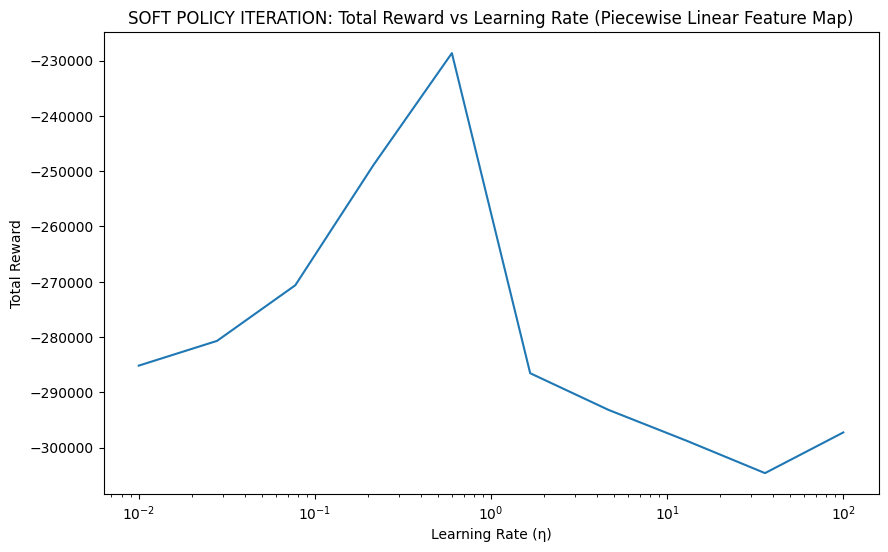

In [125]:
total_rewards_pwl = np.load('total_rewards_pwl_soft.npy')

plt.figure(figsize=(10, 6))
plt.semilogx(etas, total_rewards_pwl)
plt.xlabel('Learning Rate (η)')
plt.ylabel('Total Reward')
plt.title('SOFT POLICY ITERATION: Total Reward vs Learning Rate (Piecewise Linear Feature Map)')
plt.show()

##### Best and Worst Learning Rates for Soft Policy Iteration

In [147]:
# Load the rewards for soft policy iteration with the piecewise linear feature map
total_rewards_pwl_soft = np.load('total_rewards_pwl_soft.npy')

# Find the index of the highest and lowest total reward
index_of_best_eta = np.argmax(total_rewards_pwl_soft)
index_of_worst_eta = np.argmin(total_rewards_pwl_soft)

# Find the corresponding best and worst eta values
best_eta = etas[index_of_best_eta]
worst_eta = etas[index_of_worst_eta]

# Log-transform η values for display
log_best_eta = np.log10(best_eta)
log_worst_eta = np.log10(worst_eta)

# Print the results
print(f"The best learning rate is η = 10^{log_best_eta:.2f} with a total reward of {total_rewards_pwl_soft[index_of_best_eta]:.2f}")
print(f"The worst learning rate is η = 10^{log_worst_eta:.2f} with a total reward of {total_rewards_pwl_soft[index_of_worst_eta]:.2f}")

The best learning rate is η = 10^-0.22 with a total reward of -228649.57
The worst learning rate is η = 10^1.56 with a total reward of -304596.63


## Interpretation of Soft Policy Iteration Results

The plot illustrates the relationship between the learning rate (η) and the total reward gathered during the soft policy iteration process, using a piecewise linear feature map.

### Key Observations:
- **Peak Performance**: There is a pronounced peak in the plot, indicating an optimal learning rate where the algorithm achieves the highest total reward. This suggests that at this particular η value, the balance between exploration and exploitation is most beneficial for learning.
  
- **Performance at Low η Values**: For small values of η (learning rates less than 0.1), we observe a steady increase in total reward as η increases. This indicates that very low learning rates are not sufficient for the policy to adequately learn from the environment within the given number of iterations.

- **Performance at High η Values**: Beyond the peak, as η increases further, there is a sharp decline in total reward, implying that too high a learning rate leads to instability in the learning process. In particular, for η greater than 1, the performance drops significantly, which is characteristic of overestimation and divergence issues that can occur with high learning rates.

- **Performance at Very High η Values**: At the highest end of η values (greater than 10), the total reward again increases slightly. This may suggest that for certain high η values, the policy could still be learning, but this is likely not optimal and may be due to the specific dynamics of the MDP and feature representation.

### Optimal and Suboptimal Learning Rates:
- **Best Learning Rate**: The best learning rate is η = 10^-0.22 with a total reward of -228649.57. This learning rate achieves the highest total reward, indicating that it is the most effective for the policy to learn and optimize its decisions within the environment.

- **Worst Learning Rate**: The worst learning rate is η = 10^1.56 with a total reward of -304596.63. This represents a learning rate that is too high, leading to poor policy performance and likely instability or divergence in the learning process.

### Conclusions:
- The optimal learning rate for this specific MDP and feature map appears to be in the intermediate range, just before the sharp decline in performance.
- Both very low and very high learning rates lead to poor performance, either due to insufficient learning or due to instability and divergence.

#### Experiment 2: Pwl Feature Map ("Hard" Policy Iteration)

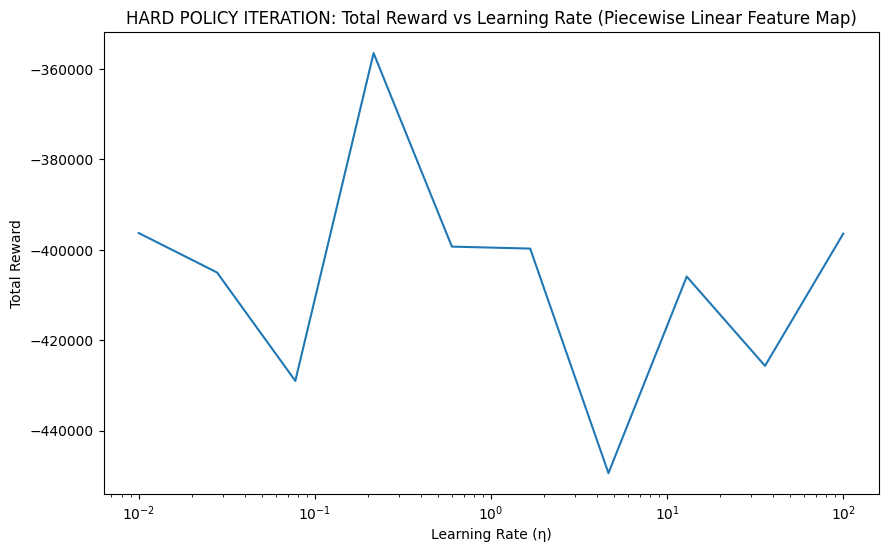

In [143]:
total_rewards_pwl_hard = np.load('total_rewards_pwl_hard.npy')

plt.figure(figsize=(10, 6))
plt.semilogx(etas, total_rewards_pwl_hard)
plt.xlabel('Learning Rate (η)')
plt.ylabel('Total Reward')
plt.title('HARD POLICY ITERATION: Total Reward vs Learning Rate (Piecewise Linear Feature Map)')
plt.show()

##### Best and Worst Learning Rates for Hard Policy Iteration

In [148]:
# Load the rewards for hard policy iteration with the piecewise linear feature map
total_rewards_pwl_hard = np.load('total_rewards_pwl_hard.npy')

# Find the index of the highest and lowest total reward
index_of_best_eta = np.argmax(total_rewards_pwl_hard)
index_of_worst_eta = np.argmin(total_rewards_pwl_hard)

# Find the corresponding best and worst eta values
best_eta = etas[index_of_best_eta]
worst_eta = etas[index_of_worst_eta]

# Log-transform η values for display
log_best_eta = np.log10(best_eta)
log_worst_eta = np.log10(worst_eta)

# Print the results
print(f"The best learning rate is η = 10^{log_best_eta:.2f} with a total reward of {total_rewards_pwl_hard[index_of_best_eta]:.2f}")
print(f"The worst learning rate is η = 10^{log_worst_eta:.2f} with a total reward of {total_rewards_pwl_hard[index_of_worst_eta]:.2f}")

The best learning rate is η = 10^-0.67 with a total reward of -356505.24
The worst learning rate is η = 10^0.67 with a total reward of -449381.34


## Interpretation of Hard Policy Iteration Results

The graph depicts the total reward obtained at varying learning rates (η) during the hard policy iteration process with a piecewise linear feature map.

### Key Observations:
- **Varying Performance**: Unlike the soft policy iteration, the performance in hard policy iteration does not show a clear and smooth peak but rather presents a more erratic behavior with several peaks and troughs. This indicates a less stable relationship between the learning rate and performance, which may suggest that hard policy iteration is more sensitive to the choice of η in this context.

- **Best and Worst Performance**: The total reward fluctuates significantly as η changes, reflecting the precise tuning required for η in hard policy iteration.

### Optimal and Suboptimal Learning Rates:
- **Best Learning Rate**: The optimal learning rate is found to be η = 10^-0.67, yielding a total reward of -356505.24. At this rate, the policy iteration process achieves its best performance, suggesting an appropriate balance between learning speed and stability. However this is still lower than the best performance achieved by soft policy iteration, indicating that the policy update mechanism in hard policy iteration may be less effective in this context.

- **Worst Learning Rate**: The least effective learning rate is η = 10^0.67, with a total reward of -449381.34. This learning rate results in the lowest total reward, indicating potential issues with instability or divergence in the learning process.

### Conclusions:
- In the context of hard policy iteration, the choice of η is critical, with performance heavily dependent on finding a learning rate that is neither too slow (leading to inadequate learning within the number of iterations) nor too fast (causing instability or divergence).

- The fluctuations in total reward across the range of η values tested suggest that hard policy iteration is more sensitive to the choice of learning rate in this context, compared to soft policy iteration.


## Analysis of Soft vs. Hard Policy Iteration

By analysing both soft and hard policy iterations, we see distinct behaviors in relation to the learning rate (η). The two plots display the total rewards earned during the learning process with varying η, utilizing a piecewise linear feature map.

### Comparison Highlights:
- **Soft Policy Iteration**: Exhibits a clear peak in performance, signifying an optimal η value. The peak indicates the highest total reward, suggesting an effective balance in the learning process.

- **Hard Policy Iteration**: Shows more erratic changes in total reward with respect to changes in η, suggesting a less stable or predictable relationship between the learning rate and performance.

### Performance at Optimal η:
- **Soft Policy Iteration Best η**: η = 10^-0.22 with a total reward of -228649.57.
- **Hard Policy Iteration Best η**: η = 10^-0.67 with a total reward of -356505.24.

The best performance in soft policy iteration surpasses that of hard policy iteration, indicating that, for the optimal values of η, soft policy iteration is more effective for this particular MDP and feature map setting.

### Performance at Suboptimal η:
- **Soft Policy Iteration Worst η**: η = 10^1.56 with a total reward of -304596.63.
- **Hard Policy Iteration Worst η**: η = 10^0.67 with a total reward of -449381.34.

At suboptimal η values, both approaches experience a decrease in performance, but the hard policy iteration appears to suffer a more significant reduction in total reward.

### Conclusion and Answer to the Stated Question:
Is there any improvement over "hard" approximate policy iteration for some value of η?

- **Yes**, soft policy iteration shows an improvement over hard policy iteration at certain values of η. Specifically, the soft policy iteration achieves a higher total reward for the optimal η found, demonstrating its better performance over the hard policy iteration in this scenario. This suggests that the soft policy update mechanism, which allows for a smoother adjustment of the policy, may be more effective and robust across a range of η values.